### Library imports

In [1]:
from fastai.vision.all import *
import fastai

In [2]:
fastai.__version__

'2.4'

In [ ]:
SEED=2021
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    #tf.set_random_seed(seed)
seed_everything(SEED)
torch.backends.cudnn.benchmark = True

### Loading and preprocessing data

In [3]:
path = Path("/data/datasets/severstal")

In [4]:
codes = ["Background", "Divots", "Cracks", "Scratches", "Ablation"]

In [7]:
def get_mask(fn):
    fn = str(fn).replace('train_images', 'masks').replace('jpg','png')
    return PILMask.create(fn)

### Using custom stats to normalize data

In [8]:
severstal_stats=([0.343], [0.197])

### Creating datablock to read grayscale images and target masks

In [60]:
dblock = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=get_image_files,
                   get_y = get_mask,
                   item_tfms=Resize(320),
                   batch_tfms=[Normalize.from_stats(*severstal_stats)]
)

In [61]:
dls=dblock.dataloaders(path/'train_images', bs=1)

### Creating custom loss function class
Still need to figure out how to avoid calculating the accuracy for background class

In [62]:
class CustomSeverstalSegComoLoss:
    "Dice and Focal combined"
    def __init__(self, axis=1, smooth=1., alpha=1.):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis)
        self.dice_loss =  DiceLoss(axis, smooth)
        
    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)
    
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

### Creating learner

In [63]:
learn = unet_learner(dls, resnet18, loss_func=CustomSeverstalSegComoLoss(axis=1), metrics=[Dice])
learn.fine_tune(10)

epoch,train_loss,valid_loss,dice,time
0,0.237689,0.194255,0.000000,11:32


epoch,train_loss,valid_loss,dice,time
0,0.114650,0.149531,0.521777,12:19
1,0.108963,0.152318,0.114506,12:21
2,0.069851,0.152890,0.080959,12:20
3,0.133413,0.206859,0.005184,12:20
4,0.081172,0.143520,0.247517,12:22
5,0.048118,0.481563,0.001282,12:22
6,0.066025,0.191557,0.000971,12:24
7,0.102145,0.166402,0.061721,12:23
8,0.095184,0.301006,0.000249,12:21
9,0.048106,0.308476,0.011094,12:21


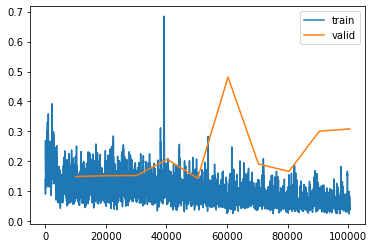

In [64]:
learn.recorder.plot_loss()